# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Train some embeddings from scratch
2. Explore embeddings vectors
3. Use these for an NLP task

In [1]:
import os
import pickle
import time
import logging
from collections import defaultdict

import nltk
nltk.__version__

import gensim
gensim.__version__

import numpy as np
np.__version__

from gensim.models import Word2Vec

import sklearn
from sklearn.manifold import TSNE

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

# Now that we're done with imports, let's download a few datasets
## First some document sets (corpora)
## Then some resources for wordlists and tokenization

In [3]:
%time nltk.download('brown')
%time nltk.download('movie_reviews')
%time nltk.download('treebank')

# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')

# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/u0420717/nltk_data...
[nltk_data]   Package brown is already up-to-date!
CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 581 ms
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/u0420717/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
CPU times: user 32 ms, sys: 16 ms, total: 48 ms
Wall time: 309 ms
[nltk_data] Downloading package treebank to
[nltk_data]     /home/u0420717/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 189 ms
[nltk_data] Downloading package punkt to /home/u0420717/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 64 ms, sys: 8 ms, total: 72 ms
Wall time: 168 ms
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u0420717/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 767 ms


True

In [4]:
#  Now we can import these
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

# Let's look at a few sentences from each of the 3 document sets
* Brown -- First million word corpus created in 1961 at Brown University
* Movie Reviews -- Reviews of movies with sentiment labels
* Penn Treebank -- Widely used dataset for part-of-speech tagging and other NLP tasks

In [5]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [6]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


# Pro Tip : Before we go on, it's good to know about the GenSim documentation for models, training, querying, etc:
https://radimrehurek.com/gensim/models/word2vec.html

# Establish some parameters for training word vectors

In [7]:
# Word2vec has two flavors -- Skip-gram (SG) and continuous bag of words (CBOW)
## Skipgram takes longer to train, so we'll disable it
W2V_SKIP_GRAM = 0
# Determine how many dimensions we want our word vectors to have in the end
W2V_DIMENSIONS = 200
# Minimum count of a token's occurrences in a corpus to be considered for training
W2V_MIN_COUNT = 3

# How many worker threads should we use to train?  Depends on your hardware...
W2V_WORKERS = 1

# Now we can train some word2vec models and time them.
## This doesn't take to long since the documents sets are relatively small and we can easily work with the sentences

In [8]:
%time brown_model = Word2Vec(brown.sents(), \
                             sg = W2V_SKIP_GRAM, \
                             size = W2V_DIMENSIONS, \
                             min_count = W2V_MIN_COUNT, \
                             workers = W2V_WORKERS)

CPU times: user 44.5 s, sys: 1.44 s, total: 46 s
Wall time: 40.5 s


In [9]:
%time movie_model = Word2Vec(movie_reviews.sents(), \
                             sg = W2V_SKIP_GRAM, \
                             size = W2V_DIMENSIONS, \
                             min_count = W2V_MIN_COUNT, \
                             workers = W2V_WORKERS)

CPU times: user 23.9 s, sys: 720 ms, total: 24.7 s
Wall time: 31 s


In [10]:
%time treebank_model = Word2Vec(treebank.sents(), \
                                sg = W2V_SKIP_GRAM, \
                                size = W2V_DIMENSIONS, \
                                min_count = W2V_MIN_COUNT, \
                                workers = W2V_WORKERS)

CPU times: user 12.2 s, sys: 800 ms, total: 13 s
Wall time: 14 s


In [11]:
# Now that these are trained, we can inspect the final vocabulary sizes for each model
print('Brown Model vocab size : ', len(brown_model.wv.vocab))
print('Movie Review Model vocab size : ', len(movie_model.wv.vocab))
print('Treebank Model vocab size : ', len(treebank_model.wv.vocab))

Brown Model vocab size :  22339
Movie Review Model vocab size :  20261
Treebank Model vocab size :  3959


# Question : Given these vocabulary sizes, which one do we expect would be the worst in translating to other tasks like text classification, information extraction, etc?
* Brown?
* Movie Reviews?
* Treebank?

# Let's see which words are in-vocabulary and out-of-vocabulary for each set

In [12]:
# do you think that the word "Spielberg" will be in each of these corpora?

VOCABULARY_WORD_1 = 'spielberg'

if VOCABULARY_WORD_1 in brown_model.wv.vocab:
    print('Word found in Brown corpus')
else:
    print('Word NOT found in Brown corpus')
    
if VOCABULARY_WORD_1 in movie_model.wv.vocab:
    print('Word found in Movie Review corpus')
else:
    print('Word NOT found in Movie Review corpus')
    
if VOCABULARY_WORD_1 in treebank_model.wv.vocab:
    print('Word found in Treebank corpus')
else:
    print('Word NOT found in Treebank corpus')

Word NOT found in Brown corpus
Word found in Movie Review corpus
Word NOT found in Treebank corpus


# Now choose another word of your own to see if it's in the vocabulary for each model

In [19]:
# do you think that the word "Spielberg" will be in each of these corpora?

VOCABULARY_WORD_2 = 'disease'

if VOCABULARY_WORD_2 in brown_model.wv.vocab:
    print('Word found in Brown corpus')
else:
    print('Word NOT found in Brown corpus')
    
if VOCABULARY_WORD_2 in movie_model.wv.vocab:
    print('Word found in Movie Review corpus')
else:
    print('Word NOT found in Movie Review corpus')
    
if VOCABULARY_WORD_2 in treebank_model.wv.vocab:
    print('Word found in Treebank corpus')
else:
    print('Word NOT found in Treebank corpus')

Word found in Brown corpus
Word found in Movie Review corpus
Word found in Treebank corpus


# Save / Load models -- This is what allows us to train them and then transfer them to be portable for other tasks

In [20]:
# Before we go any further, we can save one of our models
brown_file_name = 'brown_' + time.strftime("%m_%d_%Y")
brown_model.save(brown_file_name)
print('Saved Model to : ' + brown_file_name)

Saved Model to : brown_04_12_2018


In [21]:
# and here's how we can load a model back in...
brown_loaded_model = Word2Vec.load(brown_file_name)
print('Brown LOADED Model vocab size : ', len(brown_loaded_model.wv.vocab))

Brown LOADED Model vocab size :  22339


# Let's start inspect our newly trained vectors

In [22]:
# Now let's inspect what some of these vectors look like
print(brown_model.wv['business'])

[-4.98056039e-02  3.37853022e-02  9.55801234e-02 -2.12893322e-01
 -2.57994592e-01 -5.01809977e-02  2.70464867e-01  2.10568711e-01
  9.37233642e-02 -5.93249761e-02  2.17118021e-02 -3.18839103e-01
  5.66274226e-02  4.32767600e-01  1.68780699e-01  1.24384940e-01
 -3.98341089e-01  1.78787857e-01 -4.72455412e-01  2.53192067e-01
  3.64406593e-02 -2.06409201e-01  3.02926511e-01  5.22196554e-02
 -7.00040087e-02  1.25414386e-01 -2.16022551e-01 -1.90462284e-02
 -1.67728215e-02  1.91568702e-01  1.84698731e-01 -3.35995406e-01
 -1.72428086e-01 -3.80735553e-04 -1.62613928e-01 -2.72548586e-01
  1.74702838e-01  6.40185103e-02  1.04480587e-01  1.80164259e-02
  3.04614097e-01  1.47141248e-01  4.18300003e-01  1.30213857e-01
 -3.46031427e-01  4.83840518e-02 -9.58537832e-02 -2.27533374e-02
  6.69733107e-01  5.70005402e-02  1.70707464e-01  3.77744377e-01
  9.99802351e-02  1.87619001e-01 -1.87093556e-01  2.78558850e-01
 -2.53637850e-01 -1.24230385e-01  5.02001166e-01 -2.07879275e-01
  7.54302517e-02  3.44011

# Let's ask the model which words have the most similar vectors to a few query words

In [23]:
print(movie_model.wv.most_similar(positive = ['movie'], topn = 10))

[('film', 0.9375917911529541), ('picture', 0.8506053686141968), ('sequel', 0.7596105933189392), ('case', 0.7295717000961304), ('ending', 0.7235094308853149), ('premise', 0.7049224972724915), ('flick', 0.6949704885482788), ('story', 0.6798523664474487), ('plot', 0.6791284680366516), ('word', 0.6757405400276184)]


# Tom Hanks is a film actor -- what other words behave in a similar way in the movie corpus?

In [24]:
print(movie_model.wv.most_similar(positive = ['hanks'], topn = 10))

[('platt', 0.9403821229934692), ('campbell', 0.9398096203804016), ('jason', 0.9376640319824219), ('ian', 0.9359376430511475), ('thomas', 0.9355634450912476), ('michael', 0.9331784248352051), ('edward', 0.9324899315834045), ('richard', 0.9321949481964111), ('affleck', 0.9318617582321167), ('neve', 0.9306718111038208)]


# What about a similar word like 'talk' in a generic corpus like the Brown corpus?

In [42]:
print(brown_model.wv.most_similar(positive = ['queen'], topn = 10))

[('poet', 0.9695921540260315), ('rocking', 0.9545197486877441), ('snake', 0.9522143602371216), ('mare', 0.9475228786468506), ('pathetic', 0.9459760189056396), ('openly', 0.9456871151924133), ('maid', 0.9456337094306946), ('recital', 0.9445905089378357), ('calf', 0.944017767906189), ('angry', 0.9434125423431396)]


# Now try a few of your own in each model

In [43]:
print(brown_model.wv.most_similar(positive = ['queen'], topn = 10))

[('poet', 0.9695921540260315), ('rocking', 0.9545197486877441), ('snake', 0.9522143602371216), ('mare', 0.9475228786468506), ('pathetic', 0.9459760189056396), ('openly', 0.9456871151924133), ('maid', 0.9456337094306946), ('recital', 0.9445905089378357), ('calf', 0.944017767906189), ('angry', 0.9434125423431396)]


In [44]:
print(movie_model.wv.most_similar(positive = ['queen'], topn = 10))

[('owner', 0.9494250416755676), ('former', 0.9423737525939941), ('campbell', 0.9293302297592163), ('jay', 0.9285738468170166), ('patrick', 0.9283932447433472), ('jason', 0.9276490211486816), ('captain', 0.9269789457321167), ('kinnear', 0.9261102676391602), ('jake', 0.9255968332290649), ('jane', 0.924728274345398)]


In [46]:
# Note : This model is small with a small vocabulary so if a word doesn't exist, 
# it will throw an exception when trying to access it directly
print(treebank_model.wv.most_similar(positive = ['door'], topn = 10))

[('managers', 0.9988075494766235), ('buy', 0.9988030791282654), ('like', 0.998794674873352), ('were', 0.9987935423851013), ('certain', 0.9987921714782715), ('administration', 0.9987840056419373), ('another', 0.9987829327583313), ('now', 0.9987823963165283), ('new', 0.9987813830375671), ('them', 0.9987717270851135)]


# Another thing we can do for each model is ask how similar two words are

In [37]:
# Now let's see how similar certain word pairs might be
TERM_SIMILARITY_1 = 'movie'
TERM_SIMILARITY_2 = 'film'

print(brown_model.wv.similarity(TERM_SIMILARITY_1, TERM_SIMILARITY_2))

0.9067102909286445


In [38]:
# Now let's try another pair
TERM_SIMILARITY_3 = 'computer'
TERM_SIMILARITY_4 = 'life'

print(brown_model.wv.similarity(TERM_SIMILARITY_3, TERM_SIMILARITY_4))

0.5748152206364046


![Vector Composition](vector_composition.png)

# Now let's see if we can do some vector arithmetic to see if our model can perform well on analogy tasks

# Question : vec(families) + vec(city) - vec(family) = ???

In [39]:
# this gives what we might expect from the BROWN corpus
RELATIONSHIP_WORD_1 = 'families'
RELATIONSHIP_WORD_2 = 'city'
RELATIONSHIP_WORD_3 = 'family'

#print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('cities', 0.9450114369392395), ('various', 0.9432218074798584), ('classes', 0.9408526420593262), ('towns', 0.9350361227989197), ('programs', 0.9344204664230347), ('departments', 0.9292755722999573), ('organizations', 0.9270814061164856), ('methods', 0.9266065359115601), ('roads', 0.9258936047554016), ('policies', 0.9245615005493164)]


# Question : vec(films) + vec(movie) - vec(film) = ???

In [40]:
# this gives what we might expect from the MOVIE corpus
RELATIONSHIP_WORD_1 = 'films'
RELATIONSHIP_WORD_2 = 'movie'
RELATIONSHIP_WORD_3 = 'film'

print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))

[('movies', 0.9585886001586914), ('flicks', 0.8091394305229187), ('days', 0.7242767810821533), ('comedies', 0.7154309749603271), ('disney', 0.6937497854232788), ('fans', 0.6925614476203918), ('flick', 0.6918205618858337), ('science', 0.6907602548599243), ('genre', 0.683184802532196), ('thrillers', 0.6796923875808716)]


# Can we replicate the famous example from this paper:
## If not, why not?

In [41]:
# "King - Man + Woman ~~ Queen"
# http://www.aclweb.org/anthology/N13-1#page=784
RELATIONSHIP_WORD_1 = 'woman'
RELATIONSHIP_WORD_2 = 'king'
RELATIONSHIP_WORD_3 = 'man'

print(movie_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
print(brown_model.wv.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=[RELATIONSHIP_WORD_3]))
# apparently this corpus does not have one of our target words (KING)
#treebank_model.most_similar(positive=[RELATIONSHIP_WORD_1, RELATIONSHIP_WORD_2], negative=['man'])

[('jay', 0.8742609024047852), ('george', 0.8727226853370667), ('jane', 0.8656154870986938), ('danny', 0.8604598045349121), ('chris', 0.8592269420623779), ('jordan', 0.8586868047714233), ('robin', 0.8583725690841675), ('stewart', 0.8550280332565308), ('jason', 0.8539333343505859), ('martin', 0.8516179323196411)]
[('native', 0.9561555981636047), ('Pageant', 0.9543567895889282), ('anniversary', 0.9525343179702759), ("poet's", 0.9511545896530151), ('amplifier', 0.9497653245925903), ('facing', 0.9486056566238403), ('holding', 0.9482276439666748), ('Pacific', 0.9480260014533997), ('alveoli', 0.9470847249031067), ('dedicated', 0.9468253254890442)]


# Now let's try to visualize some of the embeddings vectors with reduced dimensions by using a visualization method called t-distributed stochastic neighbor embedding (t-SNE)

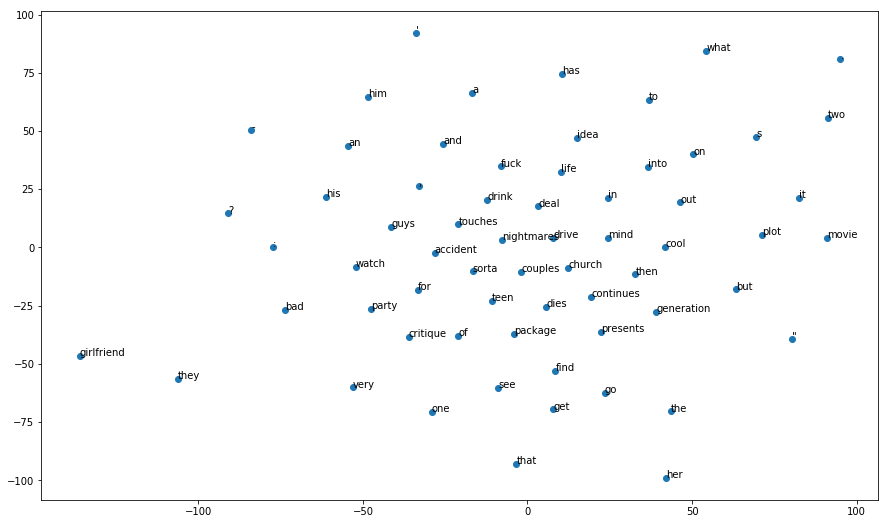

In [47]:
def plot_embeddings(w2v_model, target_terms):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        if target_term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model.wv[target_term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_terms, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
max_movie_sentences_to_visualize = 8
visualization_terms = set()
for sentence in movie_reviews.sents()[:max_movie_sentences_to_visualize]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings(movie_model, list(visualization_terms))

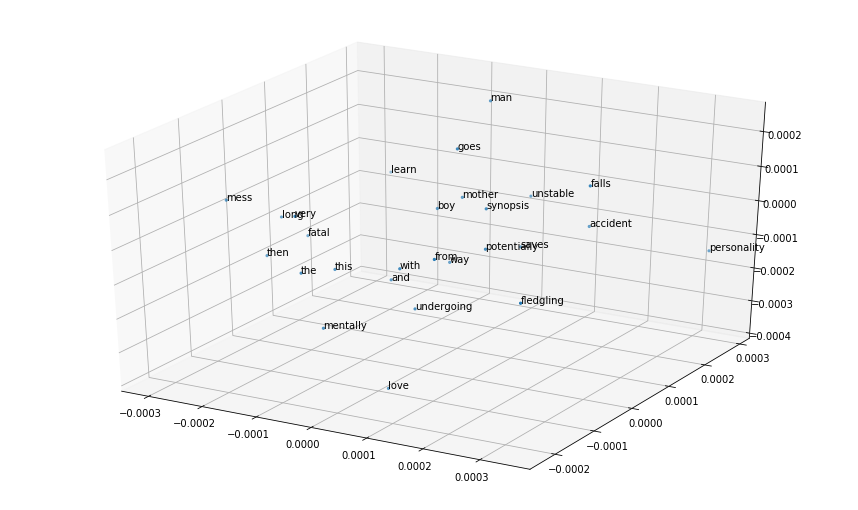

In [48]:
def plot_embeddings_3d(w2v_model, target_terms, min_word_length = 2):
    from mpl_toolkits.mplot3d import Axes3D
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    term_vectors = []
    filtered_terms = []
    # let's make sure that a term we want is in the model
    for target_term in target_terms:
        # make sure that we're either not filtering or its above a certain length
        if min_word_length < 0 or len(target_term) > min_word_length:
            if target_term in w2v_model.wv.vocab:
                term_vectors.append(w2v_model.wv[target_term])
                filtered_terms.append(target_term)
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Y[:,0], Y[:,1], Y[:,2], marker='.')
    for i, word in enumerate(filtered_terms):
        ax.text(x=Y[i,0], y=Y[i,1], z=Y[i,2], s=word)
    plt.show()
    
max_movie_sentences_to_visualize = 5
visualization_terms = set()
for sentence in movie_reviews.sents()[105:107]:
    for token in sentence:
        visualization_terms.add(token)
    
plot_embeddings_3d(movie_model, list(visualization_terms))